In [1]:
import mne
import os
import matplotlib.pyplot as plt
import numpy as np
# import spectrum
import pandas as pd
import scipy
import scipy.io

import torch

In [2]:
os.listdir("sample_data")
# data = mne.io.read_raw_edf("sample_data/ND-2014701773NTEL-C_Sélection1_Sélection1.EDF")
data = mne.io.read_raw_edf("sample_data/ND-2014701797JTEL-C_Sélection1_Sélection1.EDF")
# /Users/alexchang/OneDrive - Universite de Montreal/epilepsy-connectivity/sample_data/
# /Users/alexchang/OneDrive - Universite de Montreal/epilepsy-connectivity/sample_data/

Extracting EDF parameters from /Users/alexchang/OneDrive - Universite de Montreal/epilepsy-connectivity/sample_data/ND-2014701797JTEL-C_Sélection1_Sélection1.EDF...
EDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
ECG1, ECG2, X1, X2, X3, X4
Creating raw.info structure...


Extracting EDF parameters from /Users/alexchang/OneDrive - Universite de Montreal/epilepsy-connectivity/sample_data/ND-2014701797JTEL-C_Sélection1_Sélection1.EDF...
EDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
ECG1, ECG2, X1, X2, X3, X4
Creating raw.info structure...


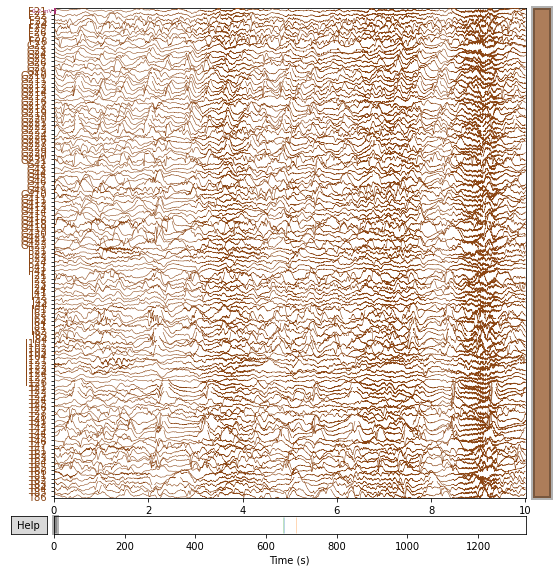

(115, 18745) ==========
Extracting EDF parameters from /Users/alexchang/OneDrive - Universite de Montreal/epilepsy-connectivity/sample_data/ND-2014701773NTEL-C_Sélection1_Sélection1.EDF...
EDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
ECG1, ECG2, X1, X2, X3, X4
Creating raw.info structure...


/usr/local/anaconda3/envs/epilepsy/lib/python3.9/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/usr/local/anaconda3/envs/epilepsy/lib/python3.9/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


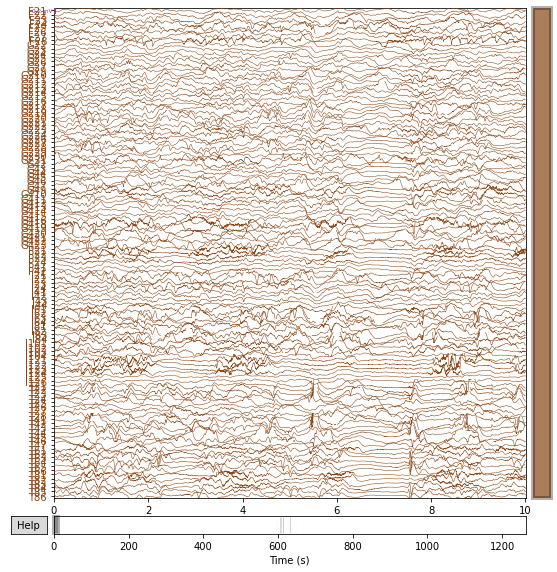

/usr/local/anaconda3/envs/epilepsy/lib/python3.9/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/usr/local/anaconda3/envs/epilepsy/lib/python3.9/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


(115, 13089) ==========


In [26]:
# ======= preprocessing ===========

def start_end_idx(data):
    '''
    Returns the index of the annotation description array 
    corresponding to the start and end of seizures.
    '''
    
    return np.where(data.annotations.description == 'Sz clin ON')[0][0], np.where(data.annotations.description == 'Sz clin OFF')[0][0]



def preprocess(fn):
    
    data = mne.io.read_raw_edf(fn)
    data.pick_types(seeg=True)
    
    # resampling removes annotations
#     data.resample(500)

    raw_data = data.get_data()
    
    p1 = np.percentile(raw_data, 1)
    p99 = np.percentile(raw_data, 99)
    
    means = np.mean(raw_data, axis=1)
    std = np.std(raw_data, axis=1)
    
    raw_data = (raw_data - means[..., np.newaxis]) / std[..., np.newaxis]
#     print(np.mean(raw_data), np.std(raw_data))
    data.plot(n_channels=128)

    start_annot_idx, end_annot_idx = start_end_idx(data)
    
    start_time = data.annotations.onset[start_annot_idx]
    end_time = data.annotations.onset[end_annot_idx]
    
    start_idx = np.where(data.times == start_time)[0][0]
    end_idx = np.where(data.times == end_time)[0][0]
    seizure = raw_data[:, start_idx:end_idx]
    
    seizure = torch.from_numpy(seizure).unsqueeze(0)
    seizure = torch.nn.functional.interpolate(seizure, scale_factor=0.25, mode="linear")
    seizure = seizure.squeeze(0).squeeze(0).numpy()
    print(seizure.shape, "==========")
    return seizure, data.ch_names


seizure1, ch_names1 = preprocess("sample_data/ND-2014701797JTEL-C_Sélection1_Sélection1.EDF")
seizure2, ch_names2 = preprocess("sample_data/ND-2014701773NTEL-C_Sélection1_Sélection1.EDF")

np.save("seizure_test1.npy", seizure1)
np.save("seizure_test2.npy", seizure2)

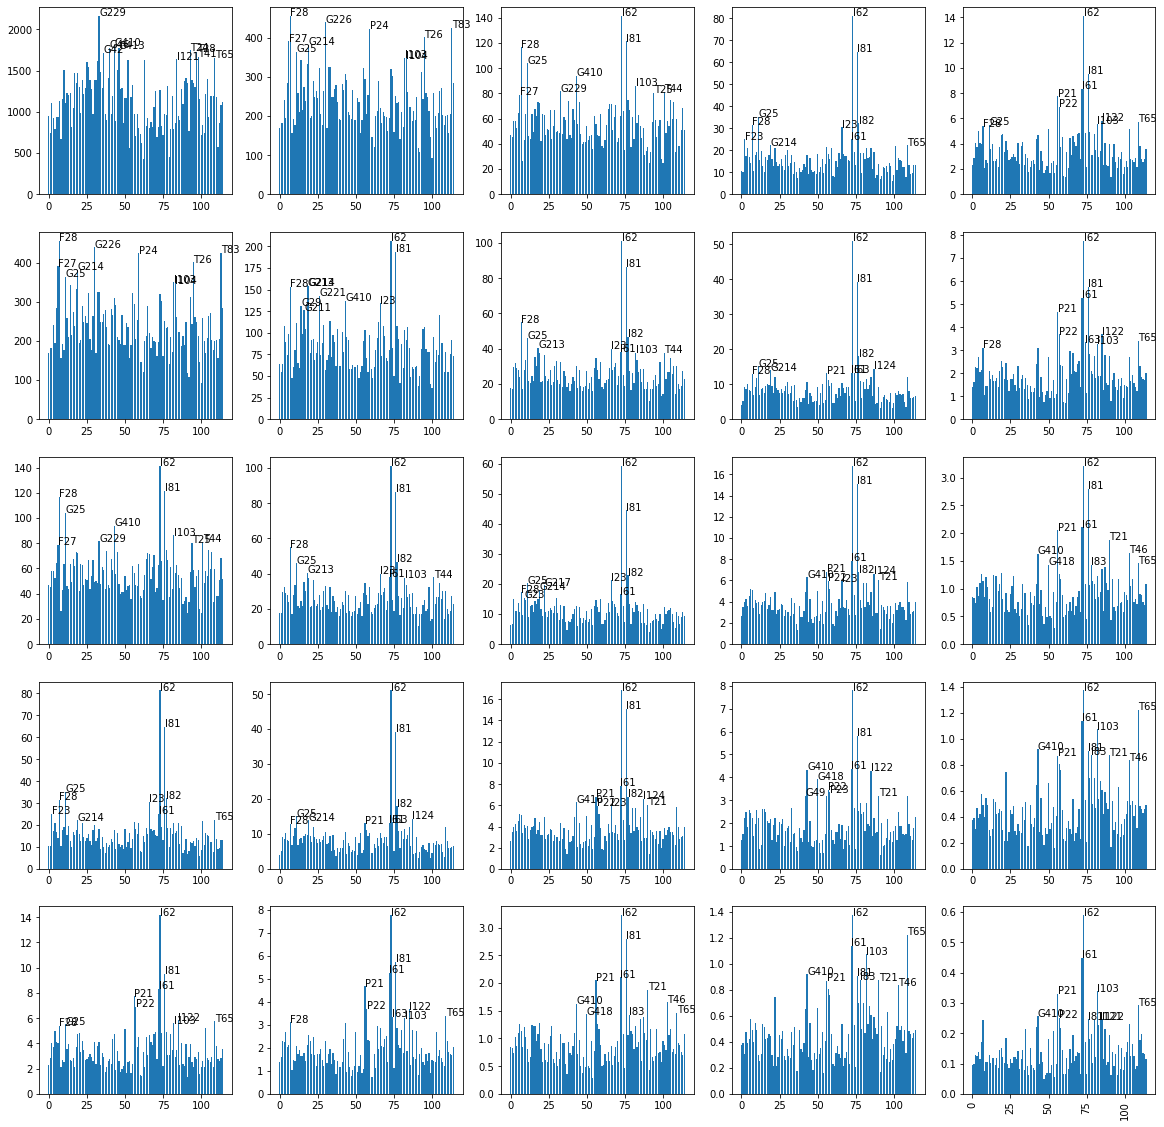

In [19]:
# ======= plotting =========

mat = scipy.io.loadmat("seizure_test2_matrices.mat")["bspecs"]


fig, axs = plt.subplots(5, 5)
fig.set_figheight(20)
fig.set_figwidth(20)


for i in range(5):
    for j in range(5):

        outflow_arr = np.sum(mat[:, :, i, j], axis=0)
        
        for k in range(10):
            q = k / 20 + 0.5
            
        q_value = np.percentile(outflow_arr, q)
        
        
        axs[i][j].bar(np.arange(115), outflow_arr)
        
        top_idx =(-outflow_arr).argsort()[:10]
        
        for k in top_idx:
            axs[i][j].text(k, outflow_arr[k], data.ch_names[k])
        
plt.xticks(rotation=90)
plt.show()
















In [15]:
for i in range(len(data.ch_names)):
    print(i, data.ch_names[i])

0 F21
1 F22
2 F23
3 F24
4 F25
5 F26
6 F27
7 F28
8 G22
9 G23
10 G24
11 G25
12 G26
13 G27
14 G29
15 G210
16 G211
17 G212
18 G213
19 G214
20 G215
21 G216
22 G217
23 G218
24 G219
25 G220
26 G221
27 G222
28 G223
29 G224
30 G226
31 G227
32 G228
33 G229
34 G230
35 G231
36 G42
37 G43
38 G44
39 G45
40 G46
41 G47
42 G49
43 G410
44 G411
45 G412
46 G413
47 G414
48 G415
49 G416
50 G418
51 G419
52 G420
53 G421
54 G422
55 G423
56 P21
57 P22
58 P23
59 P24
60 P41
61 P42
62 I21
63 I22
64 I23
65 I24
66 I41
67 I42
68 I43
69 I44
70 I61
71 I62
72 I63
73 I64
74 I81
75 I82
76 I83
77 I84
78 I101
79 I102
80 I103
81 I104
82 I121
83 I122
84 I123
85 I124
86 I125
87 I126
88 T21
89 T22
90 T23
91 T24
92 T25
93 T26
94 T27
95 T28
96 T41
97 T42
98 T43
99 T44
100 T45
101 T46
102 T47
103 T61
104 T62
105 T63
106 T64
107 T65
108 T66
109 T81
110 T82
111 T83
112 T84
113 T85
114 T86


In [12]:
# ================== testing =========================

raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
# print(raw_data.shape)

print(data.ch_names)
# print(data.get_channel_types())
data.pick_types(seeg=True)
data.resample(1000)
# print(data.info)

['F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28', 'G22', 'G23', 'G24', 'G25', 'G26', 'G27', 'G29', 'G210', 'G211', 'G212', 'G213', 'G214', 'G215', 'G216', 'G217', 'G218', 'G219', 'G220', 'G221', 'G222', 'G223', 'G224', 'G226', 'G227', 'G228', 'G229', 'G230', 'G231', 'G42', 'G43', 'G44', 'G45', 'G46', 'G47', 'G49', 'G410', 'G411', 'G412', 'G413', 'G414', 'G415', 'G416', 'G418', 'G419', 'G420', 'G421', 'G422', 'G423', 'P21', 'P22', 'P23', 'P24', 'P41', 'P42', 'ECG1', 'ECG2', 'I21', 'I22', 'I23', 'I24', 'I41', 'I42', 'I43', 'I44', 'I61', 'I62', 'I63', 'I64', 'I81', 'I82', 'I83', 'I84', 'I101', 'I102', 'I103', 'I104', 'I121', 'I122', 'I123', 'I124', 'I125', 'I126', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27', 'T28', 'T41', 'T42', 'T43', 'T44', 'T45', 'T46', 'T47', 'T61', 'T62', 'T63', 'T64', 'T65', 'T66', 'T81', 'T82', 'T83', 'T84', 'T85', 'T86', 'T3', 'C3', 'O1', 'EOG1', 'EOG2', 'EMG1', 'EMG2', 'X1', 'X2', 'X3', 'X4']


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/epilepsy/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/hl/w3d269dx5b9fr8ltdzfc5j4c0000gn/T/ipykernel_50099/3982435693.py", line 10, in <module>
    data.resample(1000)
  File "<decorator-gen-205>", line 24, in resample
  File "/usr/local/anaconda3/envs/epilepsy/lib/python3.9/site-packages/mne/io/base.py", line 1248, in resample
    resamp = resample(data_chunk, **kwargs)
  File "<decorator-gen-106>", line 24, in resample
  File "/usr/local/anaconda3/envs/epilepsy/lib/python3.9/site-packages/mne/filter.py", line 1500, in resample
    y[xi] = _fft_resample(x_, new_len, npads, to_removes,
  File "/usr/local/anaconda3/envs/epilepsy/lib/python3.9/site-packages/mne/cuda.py", line 336, in _fft_resample
    y = cuda_dict['irfft'](x_fft, new_len)
  File "/usr/local/anaconda3/envs/epilepsy/lib/python3.9/site-packag

TypeError: object of type 'NoneType' has no len()

In [58]:
import matplotlib.pyplot as plt
print(raw_data.shape)
for i in range(115):
    print(raw_data[i].shape, "====")
    print(np.std(raw_data[i]), np.mean(raw_data[i]))
    print(np.amin(raw_data[i]), np.amax(raw_data[i]))
# print(np.percentile(raw_data, 99))
# print(np.percentile(raw_data, 1))
p1 = np.percentile(raw_data, 1)
p99 = np.percentile(raw_data, 99)
print(p1, p99)



(128, 2667504)
(2667504,) ====
4.7278381434991486e-05 -1.8843109218318337e-09
-0.0002716947567711909 0.0005195428797589075
(2667504,) ====
6.109816889698706e-05 -1.4221541070859152e-08
-0.00029169444426642237 0.00029967131535820564
(2667504,) ====
0.00010091539361687693 -3.6131662578983905e-08
-0.0005930647352101929 0.0004595438172732129
(2667504,) ====
8.833186821818519e-05 -2.451822509589884e-08
-0.000583564883649958 0.00039566981533531713
(2667504,) ====
0.00011533780152496677 -3.5255576363624e-08
-0.000885310168734264 0.0005075430672617687
(2667504,) ====
8.198882788026882e-05 -8.678430748470885e-09
-0.000455566883680476 0.00038766994033722453
(2667504,) ====
7.492107356947061e-05 -3.144364319940456e-09
-0.0004396921317311359 0.00036367031534294665
(2667504,) ====
9.405419016068615e-05 -1.90455446826723e-08
-0.000791436635553521 0.00038566997158770135
(2667504,) ====
9.790243076878859e-05 -5.527219483465716e-09
-0.0003276938817578392 0.0004476690028229192
(2667504,) ====
8.72369130

-0.00039969275674067283 0.00048154347351796764
(2667504,) ====
7.883624899057581e-05 1.439579990947855e-10
-0.00055956525865568 0.0005515423797512781
(2667504,) ====
7.829973456501456e-05 -1.075163798136389e-08
-0.0004476920067292286 0.0004396691278248266
(2667504,) ====
8.737118373875011e-05 -5.492168537322762e-09
-0.0005115660086671244 0.0004156695028305487
(2667504,) ====
6.0563371419817383e-05 7.45596961286205e-09
-0.0003596933817502097 0.0003196710028534372
(2667504,) ====
4.485814355816512e-05 -1.3989865245017685e-09
-0.0003516935067521171 0.00025579700091554145
(2667504,) ====
4.8439493044920004e-05 1.7027879113844328e-09
-0.00031169413176165394 0.00027967162786297407
(2667504,) ====
0.00011977791733883044 1.9549764380588752e-08
-0.001563299574822614 0.0020305192700236516
(2667504,) ====
0.00013461058619223629 7.387507804954765e-09
-0.0015667995201342794 0.001019160072999161
(2667504,) ====
0.00012609237615635093 1.3466785140401844e-08
-0.0016427983326161592 0.000747414319157702

In [59]:
raw_data[raw_data < p1] = p1
raw_data[raw_data > p99] = p99

In [60]:
# print(data.first_time)
# print(data.times) time of each sample
# print(data.annotations.orig_time)
# print(data.annotations.duration) =0?

print(data.annotations.onset)
print(data.annotations.description)

[647.003 651.346 684.494]
['Sz clin ON' 'CRISE' 'Sz clin OFF']


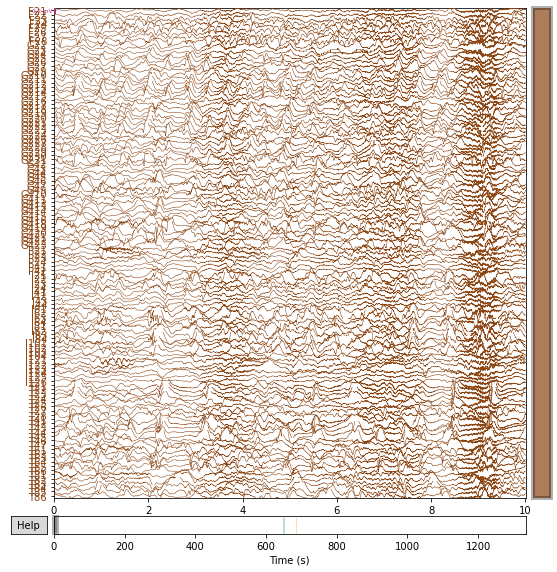

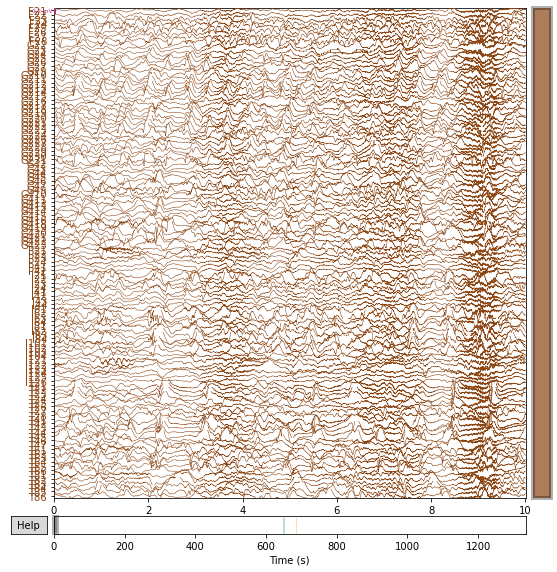

In [61]:
data.plot(n_channels=128)

In [63]:
np.save("seizure_test.npy", seizure)

In [64]:
print(seizure.shape)

ch1 = seizure[0:1, :5000].reshape(-1, 1)
ch2 = seizure[1:2, :5000].reshape(-1, 1)

(128, 37491)


In [32]:
# print(spectrum)#.bispectrumdx()
from spectrum.src3.conventional import bispectrumdx

# seizure
bspec, waxis = bispectrumdx.bispectrumdx(ch1, ch1, ch2, nfft=128, wind=5)



ModuleNotFoundError: No module named 'tools'